In [71]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import pandas as pd
from pandas import DataFrame as dframe
import cvxpy as cv

In [72]:
def Dic(feat_l_tr,feat_r_tr): #入力の配列は2次元配列である必要がある
    feat_tr = np.concatenate([feat_l_tr, feat_r_tr],0)
    return feat_tr

In [73]:
def SRC(feat_tr_dic,feat_l_te,matrix_index):
    answer = np.zeros(feat_l_te.shape[1])
    SRC_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SRC_l_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SRC_r_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    for i in range(feat_l_te.shape[1]):
        x = cv.Variable((feat_tr_dic.shape[1],1)) #目的関数の次元
        objective = cv.Minimize(cv.norm(x,1))
        constraints = [feat_l_te[:,i,np.newaxis] == feat_tr_dic@x]
        prob = cv.Problem(objective, constraints)
        result = prob.solve()
        #classVariableから値を取るためには.valueを付ける
        SRC_Cla[:,i] = np.squeeze(x.value)
        #各クラスに関連する表現ベクトルの値を抜き出す
        #lは仕切りの値
        l = 0
        j = 0
        while j < matrix_index.shape[0]-1:
            SRC_l_Cla[l:l+matrix_index[j],i] = SRC_Cla[l:l+matrix_index[j],i]     
            l = l + matrix_index[j]
            j = j + 1
            SRC_r_Cla[l:l+matrix_index[j],i] = SRC_Cla[l:l+matrix_index[j],i]
            l = l + matrix_index[j]
            j = j + 1
    #パラメータを使って擬似的に各クラスのテスト信号の特徴ベクトルを作成
    dout_feat_l_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))
    dout_feat_r_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) 
    for i in range(feat_l_te.shape[1]):
        dout_feat_l_te[:,i] = feat_tr_dic@SRC_l_Cla[:,i]
    for i in range(feat_l_te.shape[1]):
        dout_feat_r_te[:,i] = feat_tr_dic@SRC_r_Cla[:,i]
    #作成した擬似特徴ベクトルとの残差を求める
    R_l =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) #残差を格納するための配列
    R_r =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))  
    for i in range(feat_l_te.shape[1]):
        R_l[:,i] = feat_l_te[:,i]-dout_feat_l_te[:,i]
        R_r[:,i] = feat_l_te[:,i]-dout_feat_r_te[:,i]
        if np.linalg.norm(R_l[:,i], ord=2) < np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 1
        elif np.linalg.norm(R_l[:,i], ord=2) > np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 2
    return answer

In [74]:
def SRC_test(filename1,filename2,filename3,filename4,C1_K1,C2_K1,C1_K2,C2_K2,C1_K3,C2_K3,C1_K4,C2_K4):
    #対象被験者の特徴ベクトルをMATLABから入手
    feat_C1 = np.loadtxt(filename1,delimiter=",")
    feat_C2 = np.loadtxt(filename2,delimiter=",")
    feat_Test_C1 = np.loadtxt(filename3,delimiter=",")
    feat_Test_C2 = np.loadtxt(filename4,delimiter=",")
    #非対象被験者の特徴ベクトルをMATLABから入手
    feat_C1_K1 = np.loadtxt(C1_K1,delimiter=",")
    feat_C2_K1 = np.loadtxt(C2_K1,delimiter=",")
    feat_C1_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C2_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C1_K3 = np.loadtxt(C1_K3,delimiter=",")
    feat_C2_K3 = np.loadtxt(C1_K3,delimiter=",")
    feat_C1_K4 = np.loadtxt(C1_K4,delimiter=",")
    feat_C2_K4 = np.loadtxt(C1_K4,delimiter=",")
    #Tは被験者の試行回数である
    feat_tr = Dic(feat_C1,feat_C2)
    #非対象被験者の特徴ベクトルも同様の処理を行う
    feat_tr_K1 = Dic(feat_C1_K1,feat_C2_K1)
    feat_tr_K2 = Dic(feat_C1_K2,feat_C2_K2)
    feat_tr_K3 = Dic(feat_C1_K3,feat_C2_K3)
    feat_tr_K4 = Dic(feat_C1_K4,feat_C2_K4)

    #それぞれの特徴ベクトルをつなげる
    feat_tr_dic_1 = Dic(feat_tr,feat_tr_K1)
    feat_tr_dic_2 = Dic(feat_tr_dic_1,feat_tr_K2)
    feat_tr_dic_3 = Dic(feat_tr_dic_2,feat_tr_K3)
    feat_tr_dic = Dic(feat_tr_dic_3,feat_tr_K4).T
    #feat_tr_dicはすべての特徴ベクトルをつなげたもの
    #まず、分類に用いるテストデータの特徴ベクトルを2次元に変換
    feat_l_te = feat_Test_C1;
    feat_r_te = feat_Test_C2;
    feat_l_te = feat_l_te.T
    feat_r_te = feat_r_te.T

    matrix_index = np.array([feat_C1.shape[0],feat_C2.shape[0],feat_C1_K1.shape[0],feat_C2_K1.shape[0],feat_C1_K2.shape[0],feat_C2_K2.shape[0],
                        feat_C1_K3.shape[0],feat_C2_K3.shape[0],feat_C1_K4.shape[0],feat_C2_K4.shape[0]])
    answer1 = SRC(feat_tr_dic,feat_l_te,matrix_index)
    answer2 = SRC(feat_tr_dic,feat_r_te,matrix_index)
    x1 = 0
    x2 = 0
    for i in range(answer1.shape[0]):
        if answer1[i] == 1:
            x1 = x1 + 1
        if answer2[i] == 2:
            x2 = x2 + 1
    temp = ((x1+x2)/(answer1.shape[0]+answer2.shape[0]))*100
    temp1 = ((x1)/(answer1.shape[0]))*100
    temp2 = ((x2)/(answer2.shape[0]))*100
                    
    return temp,temp1,temp2

In [75]:
#train=20,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20_K0.txt","feat_2a_250Hz_20/feat_right_A01T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A01T_20.txt","feat_2a_250Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A06T_20.txt","feat_2a_250Hz_20/feat_right_A06T_20.txt","feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20_K0.txt","feat_2a_250Hz_20/feat_right_A02T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A02T_20.txt","feat_2a_250Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A06T_20.txt","feat_2a_250Hz_20/feat_right_A06T_20.txt","feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20_K0.txt","feat_2a_250Hz_20/feat_right_A03T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A03T_20.txt","feat_2a_250Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A06T_20.txt","feat_2a_250Hz_20/feat_right_A06T_20.txt","feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20_K0.txt","feat_2a_250Hz_20/feat_right_A07T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A07T_20.txt","feat_2a_250Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20_K0.txt","feat_2a_250Hz_20/feat_right_A08T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A08T_20.txt","feat_2a_250Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A09T_20_K0.txt","feat_2a_250Hz_20/feat_right_A09T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A09T_20.txt","feat_2a_250Hz_20/feat_test_right_A09T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_20/feat_left_A06T_20.txt","feat_2a_250Hz_20/feat_right_A06T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
print(probability_1)

[[50.         10.         90.        ]
 [48.75        0.         97.5       ]
 [55.         42.5        67.5       ]
 [50.         32.5        67.5       ]
 [50.          5.         95.        ]
 [68.33333333 43.33333333 93.33333333]]


In [76]:
#train=20,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20_K0.txt","feat_2a_250Hz_20/feat_right_A01T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A01T_20.txt","feat_2a_250Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A02T_20.txt","feat_2a_250Hz_20_2/feat_right_A02T_20.txt","feat_2a_250Hz_20_2/feat_left_A03T_20.txt","feat_2a_250Hz_20_2/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A06T_20.txt","feat_2a_250Hz_20_2/feat_right_A06T_20.txt","feat_2a_250Hz_20_2/feat_left_A09T_20.txt","feat_2a_250Hz_20_2/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20_K0.txt","feat_2a_250Hz_20/feat_right_A02T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A02T_20.txt","feat_2a_250Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A01T_20.txt","feat_2a_250Hz_20_2/feat_right_A01T_20.txt","feat_2a_250Hz_20_2/feat_left_A03T_20.txt","feat_2a_250Hz_20_2/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A06T_20.txt","feat_2a_250Hz_20_2/feat_right_A06T_20.txt","feat_2a_250Hz_20_2/feat_left_A09T_20.txt","feat_2a_250Hz_20_2/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20_K0.txt","feat_2a_250Hz_20/feat_right_A03T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A03T_20.txt","feat_2a_250Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A02T_20.txt","feat_2a_250Hz_20_2/feat_right_A02T_20.txt","feat_2a_250Hz_20_2/feat_left_A01T_20.txt","feat_2a_250Hz_20_2/feat_right_A01T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A06T_20.txt","feat_2a_250Hz_20_2/feat_right_A06T_20.txt","feat_2a_250Hz_20_2/feat_left_A09T_20.txt","feat_2a_250Hz_20_2/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20_K0.txt","feat_2a_250Hz_20/feat_right_A07T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A07T_20.txt","feat_2a_250Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A02T_20.txt","feat_2a_250Hz_20_2/feat_right_A02T_20.txt","feat_2a_250Hz_20_2/feat_left_A03T_20.txt","feat_2a_250Hz_20_2/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A01T_20.txt","feat_2a_250Hz_20_2/feat_right_A01T_20.txt","feat_2a_250Hz_20_2/feat_left_A09T_20.txt","feat_2a_250Hz_20_2/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20_K0.txt","feat_2a_250Hz_20/feat_right_A08T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A08T_20.txt","feat_2a_250Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A02T_20.txt","feat_2a_250Hz_20_2/feat_right_A02T_20.txt","feat_2a_250Hz_20_2/feat_left_A03T_20.txt","feat_2a_250Hz_20_2/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A01T_20.txt","feat_2a_250Hz_20_2/feat_right_A01T_20.txt","feat_2a_250Hz_20_2/feat_left_A09T_20.txt","feat_2a_250Hz_20_2/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A09T_20_K0.txt","feat_2a_250Hz_20/feat_right_A09T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A09T_20.txt","feat_2a_250Hz_20/feat_test_right_A09T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A02T_20.txt","feat_2a_250Hz_20_2/feat_right_A02T_20.txt","feat_2a_250Hz_20_2/feat_left_A03T_20.txt","feat_2a_250Hz_20_2/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A01T_20.txt","feat_2a_250Hz_20_2/feat_right_A01T_20.txt","feat_2a_250Hz_20_2/feat_left_A06T_20.txt","feat_2a_250Hz_20_2/feat_right_A06T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
print(probability_2)

[[ 51.25  12.5   90.  ]
 [ 51.25   5.    97.5 ]
 [ 51.25  30.    72.5 ]
 [ 46.25  92.5    0.  ]
 [ 58.75  75.    42.5 ]
 [ 55.    10.   100.  ]]


In [97]:
#train=20,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20_K0.txt","feat_2a_250Hz_20/feat_right_A01T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A01T_20.txt","feat_2a_250Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A02T_20.txt","feat_2a_250Hz_20_3/feat_right_A02T_20.txt","feat_2a_250Hz_20_3/feat_left_A03T_20.txt","feat_2a_250Hz_20_3/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A06T_20.txt","feat_2a_250Hz_20_3/feat_right_A06T_20.txt","feat_2a_250Hz_20_3/feat_left_A09T_20.txt","feat_2a_250Hz_20_3/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20_K0.txt","feat_2a_250Hz_20/feat_right_A02T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A02T_20.txt","feat_2a_250Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A01T_20.txt","feat_2a_250Hz_20_3/feat_right_A01T_20.txt","feat_2a_250Hz_20_3/feat_left_A03T_20.txt","feat_2a_250Hz_20_3/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A06T_20.txt","feat_2a_250Hz_20_3/feat_right_A06T_20.txt","feat_2a_250Hz_20_3/feat_left_A09T_20.txt","feat_2a_250Hz_20_3/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20_K0.txt","feat_2a_250Hz_20/feat_right_A03T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A03T_20.txt","feat_2a_250Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A02T_20.txt","feat_2a_250Hz_20_3/feat_right_A02T_20.txt","feat_2a_250Hz_20_3/feat_left_A01T_20.txt","feat_2a_250Hz_20_3/feat_right_A01T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A06T_20.txt","feat_2a_250Hz_20_3/feat_right_A06T_20.txt","feat_2a_250Hz_20_3/feat_left_A09T_20.txt","feat_2a_250Hz_20_3/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20_K0.txt","feat_2a_250Hz_20/feat_right_A07T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A07T_20.txt","feat_2a_250Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A02T_20.txt","feat_2a_250Hz_20_3/feat_right_A02T_20.txt","feat_2a_250Hz_20_3/feat_left_A03T_20.txt","feat_2a_250Hz_20_3/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A01T_20.txt","feat_2a_250Hz_20_3/feat_right_A01T_20.txt","feat_2a_250Hz_20_3/feat_left_A09T_20.txt","feat_2a_250Hz_20_3/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20_K0.txt","feat_2a_250Hz_20/feat_right_A08T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A08T_20.txt","feat_2a_250Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A02T_20.txt","feat_2a_250Hz_20_3/feat_right_A02T_20.txt","feat_2a_250Hz_20_3/feat_left_A03T_20.txt","feat_2a_250Hz_20_3/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A01T_20.txt","feat_2a_250Hz_20_3/feat_right_A01T_20.txt","feat_2a_250Hz_20_3/feat_left_A09T_20.txt","feat_2a_250Hz_20_3/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A09T_20_K0.txt","feat_2a_250Hz_20/feat_right_A09T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A09T_20.txt","feat_2a_250Hz_20/feat_test_right_A09T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A02T_20.txt","feat_2a_250Hz_20_3/feat_right_A02T_20.txt","feat_2a_250Hz_20_3/feat_left_A03T_20.txt","feat_2a_250Hz_20_3/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A01T_20.txt","feat_2a_250Hz_20_3/feat_right_A01T_20.txt","feat_2a_250Hz_20_3/feat_left_A06T_20.txt","feat_2a_250Hz_20_3/feat_right_A06T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)


probability_3 = probability.reshape([6, 3])
print(probability_3)

[[56.25       27.5        85.        ]
 [48.75       37.5        60.        ]
 [51.25       97.5         5.        ]
 [48.75       77.5        20.        ]
 [52.5        87.5        17.5       ]
 [61.66666667 80.         43.33333333]]


In [98]:
p_average_20 = (probability_1+probability_2+probability_3)/3
print(p_average_20)

[[57.5        30.         85.        ]
 [48.33333333 12.5        84.16666667]
 [51.25       80.         22.5       ]
 [50.         72.5        27.5       ]
 [50.83333333 53.33333333 48.33333333]
 [62.77777778 50.         75.55555556]]


In [79]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20_K0.txt","feat_2a_250Hz_20/feat_right_A01T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A01T_20.txt","feat_2a_250Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A06T_30.txt","feat_2a_250Hz_30/feat_right_A06T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20_K0.txt","feat_2a_250Hz_20/feat_right_A02T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A02T_20.txt","feat_2a_250Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A06T_30.txt","feat_2a_250Hz_30/feat_right_A06T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20_K0.txt","feat_2a_250Hz_20/feat_right_A03T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A03T_20.txt","feat_2a_250Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A06T_30.txt","feat_2a_250Hz_30/feat_right_A06T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20_K0.txt","feat_2a_250Hz_20/feat_right_A07T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A07T_20.txt","feat_2a_250Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20_K0.txt","feat_2a_250Hz_20/feat_right_A08T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A08T_20.txt","feat_2a_250Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A09T_20_K0.txt","feat_2a_250Hz_20/feat_right_A09T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A09T_20.txt","feat_2a_250Hz_20/feat_test_right_A09T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A06T_30.txt","feat_2a_250Hz_30/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
print(probability_1)

[[61.25       40.         82.5       ]
 [47.5         0.         95.        ]
 [45.         65.         25.        ]
 [52.5        45.         60.        ]
 [46.25       50.         42.5       ]
 [55.         16.66666667 93.33333333]]


In [80]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20_K0.txt","feat_2a_250Hz_20/feat_right_A01T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A01T_20.txt","feat_2a_250Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A06T_30.txt","feat_2a_250Hz_30_2/feat_right_A06T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20_K0.txt","feat_2a_250Hz_20/feat_right_A02T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A02T_20.txt","feat_2a_250Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A06T_30.txt","feat_2a_250Hz_30_2/feat_right_A06T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20_K0.txt","feat_2a_250Hz_20/feat_right_A03T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A03T_20.txt","feat_2a_250Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A06T_30.txt","feat_2a_250Hz_30_2/feat_right_A06T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20_K0.txt","feat_2a_250Hz_20/feat_right_A07T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A07T_20.txt","feat_2a_250Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20_K0.txt","feat_2a_250Hz_20/feat_right_A08T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A08T_20.txt","feat_2a_250Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A09T_20_K0.txt","feat_2a_250Hz_20/feat_right_A09T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A09T_20.txt","feat_2a_250Hz_20/feat_test_right_A09T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A06T_30.txt","feat_2a_250Hz_30_2/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
print(probability_2)

[[55.         22.5        87.5       ]
 [48.75        0.         97.5       ]
 [57.5        77.5        37.5       ]
 [48.75       95.          2.5       ]
 [53.75       22.5        85.        ]
 [71.66666667 53.33333333 90.        ]]


In [81]:
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20_K0.txt","feat_2a_250Hz_20/feat_right_A01T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A01T_20.txt","feat_2a_250Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A06T_30.txt","feat_2a_250Hz_30_3/feat_right_A06T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20_K0.txt","feat_2a_250Hz_20/feat_right_A02T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A02T_20.txt","feat_2a_250Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A06T_30.txt","feat_2a_250Hz_30_3/feat_right_A06T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20_K0.txt","feat_2a_250Hz_20/feat_right_A03T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A03T_20.txt","feat_2a_250Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A06T_30.txt","feat_2a_250Hz_30_3/feat_right_A06T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20_K0.txt","feat_2a_250Hz_20/feat_right_A07T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A07T_20.txt","feat_2a_250Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20_K0.txt","feat_2a_250Hz_20/feat_right_A08T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A08T_20.txt","feat_2a_250Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A09T_20_K0.txt","feat_2a_250Hz_20/feat_right_A09T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A09T_20.txt","feat_2a_250Hz_20/feat_test_right_A09T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A06T_30.txt","feat_2a_250Hz_30_3/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
print(probability_3)

[[50.         30.         70.        ]
 [50.          2.5        97.5       ]
 [56.25       50.         62.5       ]
 [48.75       95.          2.5       ]
 [50.         25.         75.        ]
 [70.         63.33333333 76.66666667]]


In [82]:
p_average_30 = (probability_1+probability_2+probability_3)/3
print(p_average_30)

[[55.41666667 30.83333333 80.        ]
 [48.75        0.83333333 96.66666667]
 [52.91666667 64.16666667 41.66666667]
 [50.         78.33333333 21.66666667]
 [50.         32.5        67.5       ]
 [65.55555556 44.44444444 86.66666667]]


In [96]:
a_20 = 0; a_30 = 0;
for i in range(6):
    a_20 = a_20 + p_average_20[i,0] 
    a_30 = a_30 + p_average_30[i,0] 
    
a_20 = a_20/6
a_30 = a_30/6
print(a_20,a_30)

53.055555555555564 53.773148148148145


[[55.41666667 48.75       52.91666667 50.         50.         65.55555556]
 [52.5        49.58333333 52.5        48.33333333 53.75       61.66666667]]


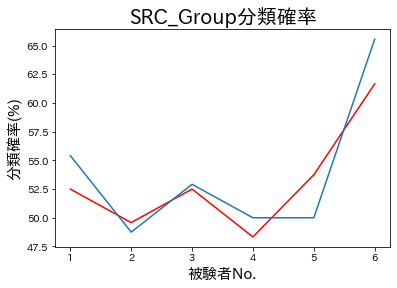

In [95]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 7, step=1)
y = np.append(p_average_20[:,0],y)
y = np.append(p_average_30[:,0],y)
y = y.reshape([2,6])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SRC_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 7, step=1))
plt.savefig("2a_SRC_group_probability_30.pdf")
plt.show()